In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir(os.getcwd())

In [2]:
os.getcwd()

'/mnt/github/RiboVsPolyA/examples'

In [10]:
#Author: Ioannis Anastopoulos
from sklearn.metrics import r2_score,confusion_matrix, accuracy_score,roc_curve,auc,precision_recall_fscore_support,f1_score, average_precision_score
from scipy.stats import pearsonr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def F_score(Y_true,predict_classes ,classes=None, plot=False,average=None):
    if classes is None:
        classes=range(len(set(Y_true)))
    eval_metrics_matrix=precision_recall_fscore_support(Y_true,predict_classes,labels=classes,average=average)
    f_score_df=pd.DataFrame(eval_metrics_matrix[2], columns=['F_score'],index=classes)
    f_score_df=f_score_df.drop_duplicates()

    if plot:
        plt.figure(figsize=(10,10))
        ax=f_score_df.plot(kind='bar', figsize=(7,10))
        for p in ax.patches:
            ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005))
        plt.title('F1_score')
        plt.show()
        plt.close()
    return f_score_df

def confusion(Y_true,predict_classes,classes=None,plot=False, title='Confusion Matrix',fontsize=16,cmap='tab20',normalize=False):

    if classes is None:
        classes=range(len(set(predict_classes)))

    conf_matrix=confusion_matrix(Y_true, predict_classes, labels=classes)

    if normalize:
        total=conf_matrix.sum(axis=0) #summing actual predictions
        conf_matrix= conf_matrix/total

    df_cm = pd.DataFrame(conf_matrix, index=classes,
                  columns=classes)
    #sns.set(font_scale=5)#for label size
    if plot:
        plt.figure(figsize=(10,10))
        sns.heatmap(df_cm, annot=True,annot_kws={"size":fontsize*(1/2) },cmap=cmap)# font size
        #fig=conf_hm.get_figure()
        plt.yticks(fontsize=fontsize+4)
        plt.xticks(fontsize=fontsize+4)
        plt.title(title, fontsize=fontsize+10)
        #fig.savefig(out,dpi=300)
        plt.show()
        plt.close()

    return conf_matrix

def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    return np.eye(num_classes, dtype='uint8')[y]

def ROC(y_true, y_pred,classes=None,title=None,plot=False):

    plt.figure(figsize=(10,10))
    lw=4

    if isinstance(y_true, pd.DataFrame):
        y_true=y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred=y_pred.values


    if classes is None:
        classes=set(list(y_true.flatten())) #removing dups, and i think itll only work for binary cases

    if len(classes)>2:
        #y_true = to_categorical(y_true, len(classes))
        #y_pred = to_categorical(y_pred, len(classes))
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i,cl in enumerate(classes):
            fpr[cl], tpr[cl], _ = roc_curve(y_true[:,i], y_pred[:, i])
            roc_auc[cl] = auc(fpr[cl], tpr[cl])
        
        if plot: 
            colors = plt.cm.get_cmap('tab20',len(classes)) #best line of code IN THE UNIVERSE

            for i, color in zip(range(len(classes)), colors.colors):
                cl = classes[i]
                plt.plot(fpr[cl], tpr[cl], color=colors.colors[i], lw=lw,
                     label='ROC curve of class {0} (area = {1:0.2f})'
                     ''.format(cl, roc_auc[cl]))
            plt.plot([0, 1], [0, 1], 'k--', lw=lw)
            plt.xlim([-0.03, 1.05])
            plt.ylim([-0.03, 1.05])
            plt.xlabel('False Positive Rate', fontsize=10)
            plt.ylabel('True Positive Rate',fontsize=10)
            plt.title(title, fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend(loc="lower right",prop={'size': 15})
            #plt.savefig('/projects/sysbio/users/ianastop/cm_region_results/plots/%s_ROC.png'%self.out,dpi=300)
            plt.show()
            plt.close()

        return (fpr, tpr, roc_auc)

    else:
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        if plot:
            plt.plot(fpr, tpr, color='darkorange', lw=4, label='ROC curve (area = %0.2f)' % roc_auc)

            plt.plot([0, 1], [0, 1], 'k--', lw=lw)
            plt.xlim([-0.03, 1.05])
            plt.ylim([-0.03, 1.05])
            plt.xlabel('False Positive Rate', fontsize=10)
            plt.ylabel('True Positive Rate',fontsize=10)
            plt.title(title, fontsize=12)
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)
            plt.legend(loc="lower right",prop={'size': 10})
            #plt.savefig('/projects/sysbio/users/ianastop/cm_region_results/plots/%s_ROC.png'%self.out,dpi=300)
            return( fpr, tpr, roc_auc)
            plt.show()
            plt.close()
        print(fpr, tpr)
        return fpr,tpr,roc_auc


def regression_eval(y_true,y_pred, axis=None):
    '''
    Function computes pearson, r2 and rmse row wise or column wise
    Returns a list for each metric for each row or column

    axis =0/1 if the vector predicted has multiple rows and columns: for expression matrices
    if the vectors has multiple samples predicted for 1 variable : for drug response vector of each drug individually
    '''
    #calculating metrics on a per sample basis
    if axis ==0:
        r_list = []
        r2_list = []
        rmse_list = []
        for i, vec in enumerate(y_true):
            r_list +=[pearsonr(vec, y_pred[i])[0]]
            r2_list += [r2_score(vec, y_pred[i])]
            rmse_list += [rmse(vec,y_pred[i])]
        r = np.mean(r_list)
        r2 = np.mean(r2_list)
        rmse_score = np.mean(rmse_list)
    elif axis == 1:
        r_list = []
        r2_list = []
        rmse_list = []
        for i, vec in enumerate(y_true.T):
            r_list +=[pearsonr(vec, y_pred.T[i])[0]]
            r2_list += [r2_score(vec, y_pred.T[i])]
            rmse_list += [rmse(vec,y_pred.T[i])]
        r = np.mean(r_list)
        r2 = np.mean(r2_list)
        rmse_score = np.mean(rmse_list)
    elif axis is None:
        r, _ = pearsonr(y_true.flatten(), y_pred.flatten())
        r2 = r2_score(y_true.flatten(), y_pred.flatten())
        rmse_score = rmse(y_true.flatten(), y_pred.flatten())
    return r,r2,rmse_score

def classification_eval(y_true,y_pred, y_proba,classes=None):
    if len(y_proba.shape)>=2:
        y_pred = np.argmax(y_proba, axis=1)
    acc = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = ROC(y_true, y_proba,classes=classes)[-1]
    precision = average_precision_score(y_true, y_proba, average='weighted')
    
    return acc, f1, roc_auc, precision
        
def node_classification_eval():
    pass 

def corr_plot(y_true, y_pred, title='Fig Title', ylabel='Y label', xlabel='X label', out_fn='out.png', log_values=False):
    fig, axes = plt.subplots(nrows=3, ncols=3,figsize=(10,10))
    i=0
    j=0
    np.random.seed(42)
    for idx,sample_idx in enumerate(np.random.choice(np.arange(y_true.shape[0]),9)):

        ax_row =axes[i] #select row  to plot in
        ax = ax_row[j]
        if log_values:
            observed = [np.log(x+1) for x in y_true[int(sample_idx/2)]]
            predicted = [np.log(x+1) for x in y_pred[int(sample_idx/2)]]
        else:
            observed = y_true[int(sample_idx/2)]
            predicted = y_pred[int(sample_idx/2)]
            
        ax.scatter(observed, predicted, s=1, alpha=0.6, marker='o')

        ax.set_title("Random sample %d"%(idx+1))

        if j==2:
            i+=1
            j=0
        else:
            j+=1
        r = pearsonr(y_true[int(sample_idx/2)], y_pred[int(sample_idx/2)])[0]
        r2 = r2_score(y_true[int(sample_idx/2)], y_pred[int(sample_idx/2)])
        ax.text(min(observed), 0.95*max(predicted), 'pearson coeff: %.3f'%r)
        ax.text(min(observed), 0.8*max(predicted), r'$R^2$: %.3f'%r2)

    #     handles, labels = ax.get_legend_handles_labels()
    #     by_label = dict(zip(labels, handles))
    #     ax.legend(by_label.values(), by_label.keys())
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_xlabel(xlabel, fontsize=10)

    st = fig.suptitle(title, fontsize=15)
    st.set_y(1.05)
    fig.subplots_adjust(top=0.85)

    plt.tight_layout()
    plt.savefig(out_fn, dpi=300)
    plt.show()
    plt.close()


In [20]:
srp_tpm_df = pd.read_csv("../results/SRP127360_TPM_log2_plus_1.balanced_maxdepth1_results.tsv", index_col=0, sep='\t')

In [28]:
srp_tpm_df

,Ribo,Proba_0,Proba_1
B_M_2,0.0,0.917177,0.082823
B_M_3,0.0,0.909384,0.090616
B_M_1,0.0,0.892943,0.107057
B_M_4,0.0,0.917177,0.082823
B_T_2,1.0,0.363504,0.636496
B_T_1,1.0,0.308447,0.691553
C_M_1,0.0,0.824904,0.175096
B_T_4,1.0,0.318240,0.681760
B_T_3,1.0,0.361659,0.638341
C_M_3,0.0,0.877366,0.122634


In [21]:
srp_tpm_df.shape

(16, 3)

In [32]:
true_labels = [0 if 'M' in x else 1 for x in srp_tpm_df.index]
pred_labels = srp_tpm_df.Ribo.values
pred_proba = srp_tpm_df.Proba_1.values

In [33]:
true_labels

[0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1]

In [34]:
pred_labels

array([0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1.])

In [35]:
pred_proba

array([0.08282345, 0.09061604, 0.10705678, 0.08282345, 0.63649559,
       0.69155317, 0.17509634, 0.68176017, 0.63834146, 0.12263352,
       0.12369764, 0.11528636, 0.76537756, 0.76716429, 0.76619201,
       0.77489461])

In [36]:
acc, f1, roc_auc, precision = classification_eval(true_labels, pred_labels,pred_proba, classes={0,1})
print('Accuracy: {}\nF1-score: {}\nROC_AUC: {}'.format(acc, f1, roc_auc))

[0.   0.   0.   0.75 1.  ] [0.    0.125 1.    1.    1.   ]
Accuracy: 1.0
F1-score: 1.0
ROC_AUC: 1.0


<Figure size 720x720 with 0 Axes>

(array([0.  , 0.  , 0.  , 0.75, 1.  ]),
 array([0.   , 0.125, 1.   , 1.   , 1.   ]),
 1.0)

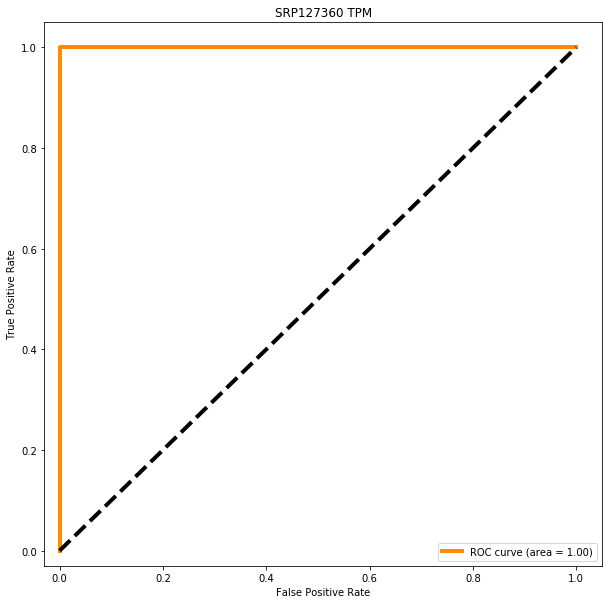

In [38]:
ROC(true_labels, pred_proba, classes={0,1}, plot=True, title='SRP127360 TPM')

In [9]:
confusion(true_labels, list(pred_labels), plot=True, title='SRP127360 TPM Confusion Matrix',fontsize=16,cmap='tab20',normalize=False)


ValueError: At least one label specified must be in y_true

In [ ]:
pred_labels.reshape(-1,1).shape

In [ ]:
srp_fpkm_df = pd.read_csv("../results/SRP127360_FPKM_log2_plus_1.balanced_maxdepth1_results.tsv", index_col=0, sep='\t')
true_labels = np.array([1 if 'T' in x else 0 for x in srp_fpkm_df.index])
pred_labels = srp_fpkm_df.Ribo.values

In [ ]:
acc, f1, roc_auc = classification_eval(true_labels, pred_labels, classes={0,1})
print('Accuracy: {}\nF1-score: {}\nROC_AUC: {}'.format(acc, f1, roc_auc))

In [ ]:
ROC(true_labels, pred_labels, classes={0,1}, plot=True,title='SRP127360 FPKM')

In [ ]:
confusion(true_labels, list(pred_labels), plot=True, title='SRP127360 FPKM Confusion Matrix',fontsize=16,cmap='tab20',normalize=False)
